In [2]:
import os
import torch
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
%matplotlib inline

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/SDDsubset.zip -d /content/drive/MyDrive
!unzip /content/drive/MyDrive/Colab_Notebooks/DBIsubset.zip -d /content/drive/MyDrive

Archive:  /content/drive/MyDrive/Colab_Notebooks/SDDsubset.zip
replace /content/drive/MyDrive/SDDsubset/bernese_mountain_dog/n02107683_1003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/drive/MyDrive/Colab_Notebooks/DBIsubset.zip
replace /content/drive/MyDrive/DBIsubset/bernese_mountain_dog/bernese1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
dataset_DBI = ImageFolder('/content/drive/MyDrive/DBIsubset')
dataset_SDD = ImageFolder('/content/drive/MyDrive/SDDsubset')
dataset = dataset_DBI

In [4]:
print(len(dataset_DBI ))
print(len(dataset_DBI.classes))
print(len(dataset_SDD ))
print(len(dataset_SDD.classes))

646
7
1233
7


In [5]:
breeds = []
for n in dataset.classes:
    breeds.append(n)
breeds

['bernese_mountain_dog',
 'border_collie',
 'chihuahua',
 'golden_retriever',
 'labrador_retriever',
 'pug',
 'siberian_husky']

In [6]:
random_seed = 45
torch.manual_seed(random_seed);

In [7]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

(408, 45, 193)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(408, 45, 193)

golden_retriever
<class 'PIL.Image.Image'>


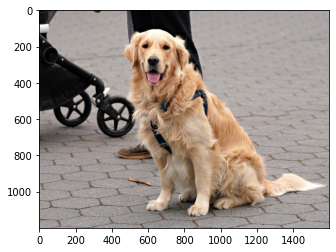

In [9]:
img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

In [10]:
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

In [11]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

In [12]:
train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

3


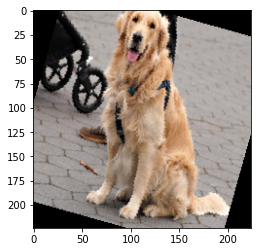

In [13]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [14]:
batch_size = 10

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [15]:
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

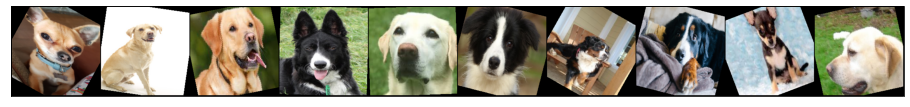

In [16]:
show_batch(train_dl)

In [17]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [36]:
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, targets)
        return loss

    def training_step_x(self, batch):
        img, targets = batch
        out = self(img)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, targets)
        acc = accuracy(out, targets)
        return {'train_acc':acc.detach(), 'train_loss':loss.detach()}
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
        
    # test step
    def test_step(self, batch):
        img, targets = batch
        out = self(img)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, targets)
        acc = accuracy(out, targets)
        return {'test_acc':acc.detach(), 'test_loss':loss.detach()}
    
    def validation_epoch_end(self, outputs_train, outputs_val, outputs_test):
        batch_losses = [x['train_loss'] for x in outputs_train]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['train_acc'] for x in outputs_train]
        epoch_acc = torch.stack(batch_accs).mean()
        epoch_dict = {'train_loss':epoch_loss.item(), 'train_acc':epoch_acc.item()}

        batch_losses = [x['test_loss'] for x in outputs_test]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['test_acc'] for x in outputs_test]
        epoch_acc = torch.stack(batch_accs).mean()
        epoch_dict_2 = {'test_loss':epoch_loss.item(), 'test_acc':epoch_acc.item()}
        epoch_dict = dict(epoch_dict_2, **epoch_dict)

        batch_losses = [x['val_loss'] for x in outputs_val]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs_val]
        epoch_acc = torch.stack(batch_accs).mean()
        epoch_dict_3 = {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        epoch_dict = dict(epoch_dict_3, **epoch_dict)
        return epoch_dict
    
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))
        

In [19]:
class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(56*56*8, 32),
            # nn.Dropout(0.5),
            nn.Softmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [37]:
model = DogBreedClassificationCNN()
model

DogBreedClassificationCNN(
  (network): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout(p=0.5, inplace=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=25088, out_features=32, bias=True)
    (13): Softmax(dim=1)
  )
)

In [38]:
class DogBreedPretrainedResnet34(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_34 = DogBreedPretrainedResnet34()
model_34

In [41]:
class DogBreedPretrainedResnet18(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_18 = DogBreedPretrainedResnet18()
model_18

In [26]:
class DogBreedPretrainedResnet32(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 7),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model_32 = DogBreedPretrainedResnet32()
model_32

In [28]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    else:
        return data.to(device, non_blocking=True)

In [29]:
class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)

In [42]:
model1 = model_18

In [43]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# moving model to gpu
to_device(model1, device);

cuda


In [ ]:
# check the model 
def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        outs = model1(imgs)                                  # Change model object here
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        
try_batch(train_dl)

In [34]:
from tqdm.notebook import tqdm

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, test_loader, weight_decay=0, grad_clip=None, opt_func = torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # set up one cycle lr scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        # Training phase
        model.train()       
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            
            # calculates gradients
            loss.backward()
            
            # check gradient clipping 
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            # perform gradient descent and modifies the weights
            optimizer.step()
            
            # reset the gradients
            optimizer.zero_grad()
            
            # record and update lr
            lrs.append(get_lr(optimizer))
            
            # modifies the lr value
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader, train_loader, test_loader)

        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
        
    return history
        
    

@torch.no_grad()
def evaluate(model, val_loader, train_loader, test_loader, accuracy_type=''):
    model.eval()
    outputs_val = [model.validation_step(batch) for batch in val_loader]
    outputs_train = [model.training_step_x(batch) for batch in train_loader]
    outputs_test = [model.test_step(batch) for batch in test_loader]


    return model.validation_epoch_end(outputs_train, outputs_val, outputs_test)

In [40]:
evaluate(model1, val_dl, train_dl, test_dl)                 # change model object here

KeyboardInterrupt: ignored

In [44]:
# set hyperparams
num_epochs = 10
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

In [ ]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

In [46]:
history[0].keys()

dict_keys(['val_loss', 'val_acc', 'test_loss', 'test_acc', 'train_loss', 'train_acc', 'lrs'])

In [47]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])

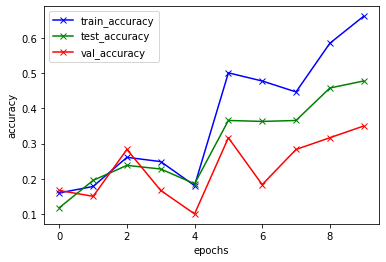

The final test accuracy is:  0.4780769348144531


In [49]:
# plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.plot(time, train_acc, c='blue', label='train_accuracy', marker='x')
plt.plot(time, test_acc, c='green', label='test_accuracy', marker='x')
plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print("The final test accuracy for ResNet18 without pretrain, in DBI is: ", test_acc[-1])

In [ ]:
to_device(model_34, device)
history = fit_one_cycle(num_epochs, max_lr, model_34, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

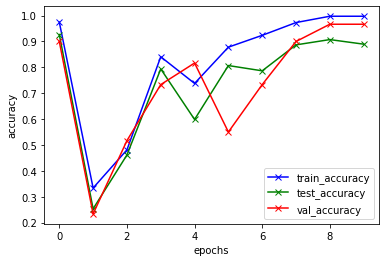

The final test accuracy for ResNet34, DBI is:  0.8896154165267944


In [51]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])
# plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.plot(time, train_acc, c='blue', label='train_accuracy', marker='x')
plt.plot(time, test_acc, c='green', label='test_accuracy', marker='x')
plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print("The final test accuracy for ResNet34, DBI is: ", test_acc[-1])

In [52]:
to_device(model_34, device)
history = fit_one_cycle(num_epochs, max_lr, model_34, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 0.1097, val_loss: 0.2282, val_acc: 0.9667


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.1245, val_loss: 0.3622, val_acc: 0.8500


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.1247, val_loss: 1.2078, val_acc: 0.7833


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.2188, val_loss: 0.3971, val_acc: 0.8667


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.3365, val_loss: 0.4497, val_acc: 0.8833


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.3554, val_loss: 0.6642, val_acc: 0.7333


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.3194, val_loss: 0.2715, val_acc: 0.9167


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.1049, val_loss: 0.3406, val_acc: 0.9000


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.0705, val_loss: 0.2545, val_acc: 0.9167


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0526, val_loss: 0.1859, val_acc: 0.9333


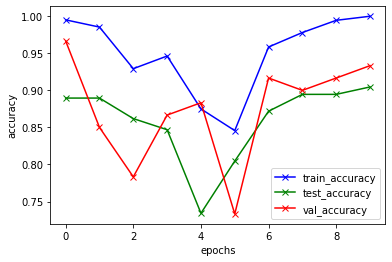

The final test accuracy for ResNet32, DBI is:  0.9046152830123901


In [53]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])
# plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.plot(time, train_acc, c='blue', label='train_accuracy', marker='x')
plt.plot(time, test_acc, c='green', label='test_accuracy', marker='x')
plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print("The final test accuracy for ResNet32, DBI is: ", test_acc[-1])

In [54]:
to_device(model, device)
history = fit_one_cycle(num_epochs, max_lr, model, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 3.4166, val_loss: 3.3606, val_acc: 0.1333


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 3.2500, val_loss: 3.2821, val_acc: 0.2500


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 3.2506, val_loss: 3.3143, val_acc: 0.2000


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 3.2581, val_loss: 3.3795, val_acc: 0.1333


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 3.2652, val_loss: 3.3020, val_acc: 0.1667


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 3.2766, val_loss: 3.3014, val_acc: 0.2167


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 3.2485, val_loss: 3.2173, val_acc: 0.3000


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 3.2473, val_loss: 3.2680, val_acc: 0.2500


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 3.2485, val_loss: 3.2866, val_acc: 0.2333


  0%|          | 0/41 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 3.2226, val_loss: 3.2850, val_acc: 0.2333


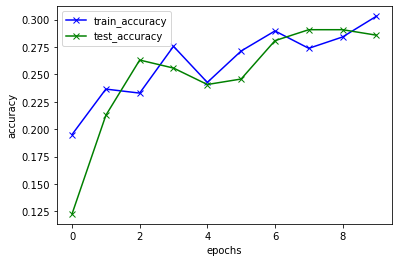

The final test accuracy for My CNN without dropout, in DBI is:  0.2857692241668701


In [56]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])
plt.plot(time, train_acc, c='blue', label='train_accuracy', marker='x')
plt.plot(time, test_acc, c='green', label='test_accuracy', marker='x')
# plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print("The final test accuracy for My CNN without dropout, in DBI is: ", test_acc[-1])

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Task5_data.zip -d /content/drive/MyDrive

In [57]:
dataset_task_5 = ImageFolder('/content/drive/MyDrive/Task5_data')
dataset = dataset_task_5

In [58]:
print(len(dataset_task_5 ))
print(len(dataset_task_5.classes))

1879
2


In [59]:
random_seed = 45
torch.manual_seed(random_seed);

DBIsubset
<class 'PIL.Image.Image'>


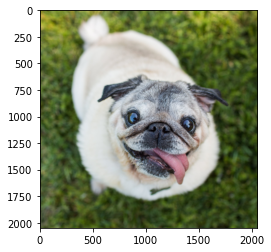

In [60]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size

val_pct = 0.1
val_size = int(dataset_size*val_pct)
train_size = dataset_size - val_size


train_size, val_size, test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

img, label = train_ds[6]
print(dataset.classes[label])
plt.imshow(img)
print(type(img))

0


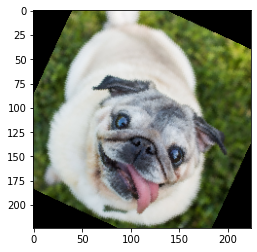

In [61]:
train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])


val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
])

train_dataset = DogBreedDataset(train_ds, train_transform)
val_dataset = DogBreedDataset(val_ds, val_transform)
test_dataset = DogBreedDataset(test_ds, test_transform)

img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

In [62]:
batch_size = 16

# Create DataLoaders
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_dataset, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_dataset, batch_size*2, num_workers=2, pin_memory=True)

In [63]:
class DogBreedPretrainedResnet32_task5(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, xb):
        return self.network(xb)

In [64]:
model1 = DogBreedPretrainedResnet32_task5()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
# getting default device
device = get_default_device()
print(device)

# moving train dataloader and val dataloader to gpu
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)


# moving model to gpu
to_device(model1, device);

cuda


In [66]:
history = fit_one_cycle(num_epochs, max_lr, model1, train_dl, val_dl, test_dl, weight_decay, grad_clip, opt_func)

  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [0] : train_loss: 0.4980, val_loss: 0.6397, val_acc: 0.7167


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [1] : train_loss: 0.4272, val_loss: 0.3877, val_acc: 0.8062


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [2] : train_loss: 0.3690, val_loss: 0.6300, val_acc: 0.8313


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [3] : train_loss: 0.4395, val_loss: 0.5092, val_acc: 0.8687


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [4] : train_loss: 0.4526, val_loss: 0.3704, val_acc: 0.8438


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [5] : train_loss: 0.3868, val_loss: 0.4967, val_acc: 0.8188


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [6] : train_loss: 0.2648, val_loss: 0.5021, val_acc: 0.8875


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [7] : train_loss: 0.1706, val_loss: 0.3567, val_acc: 0.8438


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [8] : train_loss: 0.1098, val_loss: 0.3286, val_acc: 0.9125


  0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch [9] : train_loss: 0.0800, val_loss: 0.3343, val_acc: 0.8938


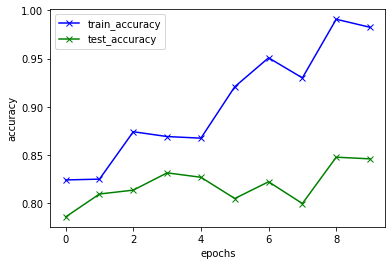

The final test accuracy for ResNet32, of DBI/SDI is:  0.8460343480110168


In [68]:
val_loss = []
train_loss = []
val_acc = []
train_acc = []
test_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])
    train_acc.append(h['train_acc'])
    test_acc.append(h['test_acc'])
plt.plot(time, train_acc, c='blue', label='train_accuracy', marker='x')
plt.plot(time, test_acc, c='green', label='test_accuracy', marker='x')
# plt.plot(time, val_acc, c='red', label='val_accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print("The final test accuracy for ResNet32, of DBI/SDI is: ", test_acc[-1])